In [1]:
import os
os.environ['TRKXINPUTDIR']="/global/cfs/projectdirs/atlas/xju/heptrkx/trackml_inputs/train_all"
os.environ['TRKXOUTPUTDIR']= "/global/cfs/projectdirs/m3443/usr/caditi97/iml2020/outtest" 

In [2]:
import pickle
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import sys
import warnings
warnings.filterwarnings('ignore')
from os import listdir
from os.path import isfile, join
import math


sys.path.append('/global/homes/c/caditi97/exatrkx-iml2020/exatrkx/src/')

# 3rd party
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from trackml.dataset import load_event
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint


# local import
from exatrkx import config_dict # for accessing predefined configuration files
from exatrkx import outdir_dict # for accessing predefined output directories
from exatrkx.src import utils_dir
from exatrkx.src import utils_robust
from utils_robust import *


# for preprocessing
from exatrkx import FeatureStore
from exatrkx.src import utils_torch

# for embedding
from exatrkx import LayerlessEmbedding
from exatrkx.src import utils_torch
from torch_cluster import radius_graph
from utils_torch import build_edges
from embedding.embedding_base import *

# for filtering
from exatrkx import VanillaFilter

# for GNN
import tensorflow as tf
from graph_nets import utils_tf
from exatrkx import SegmentClassifier
import sonnet as snt

# for labeling
from exatrkx.scripts.tracks_from_gnn import prepare as prepare_labeling
from exatrkx.scripts.tracks_from_gnn import clustering as dbscan_clustering

# track efficiency
from trackml.score import _analyze_tracks
from exatrkx.scripts.eval_reco_trkx import make_cmp_plot, pt_configs, eta_configs,get_ratio,pairwise
from functools import partial

In [3]:
def open_pickle(pickle_dir):
    with open(pickle_dir, 'rb') as handle:
        unpickler = pickle.Unpickler(handle)
        b = unpickler.load()
    return b

In [4]:
def get_pickle_data(n, list_data):
    
    pickle_dir = f"/global/cfs/projectdirs/m3443/usr/caditi97/iml2020/noise_100events/lists_n{n}.pickle"
    list_data[f'{n}'] = open_pickle(pickle_dir)
    d = list_data[f'{n}']

In [5]:
def get_ratio(x_vals, y_vals):
    res = [x/y if y!=0 else 0.0 for x,y in zip(x_vals, y_vals)]
    err = [x/y * math.sqrt((x+y)/(x*y)) if y!=0 and x!=0 else 0.0 for x,y in zip(x_vals, y_vals)]
    return res[1:], err[1:]

In [6]:
def mcp(xarray, yarray, xlegend, ylegend, configs, xlabel, ylabel, ratio_label, ax1, ax2):
    #pt_bins = [-0.1, 0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 5]
    # pt_bins = [-0.1, 0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.5, 1.9, 2.4, 5]
    # pt_bins = [0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1, 4]

    m_vals, bins, _ = ax1.hist(xarray, **configs, label=xlegend)
    n_vals, _, _ = ax1.hist(yarray, **configs, label=ylegend)
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)
    ax1.grid(True)
    ax1.legend()
    

    ratio, ratio_err = get_ratio(m_vals, n_vals)
    xvals = [0.5*(x[1]+x[0]) for x in pairwise(bins)][1:]
    xerrs = [0.5*(x[1]-x[0]) for x in pairwise(bins)][1:]
    # print(xvals)
    ax2.errorbar(xvals, ratio, yerr=ratio_err, fmt='o', xerr=xerrs, lw=2)
    ax2.set_xlabel(xlabel)
    ax2.set_ylabel(ratio_label)
    ax2.set_yticks(np.arange(0.5, 1.05, step=0.05))
    ax2.set_ylim(0.5, 1.05)
    ax2.grid(True)
#     ax2.text(1, 0.8, "bins: [{}] GeV".format(", ".join(["{:.1f}".format(x) for x in pt_bins[1:]])))
    return xvals, xerrs, ratio, ratio_err, m_vals, n_vals

In [7]:
def div_unc(n,d,f,n_std,d_std):
    f_err = np.sqrt((n_std/n)**2 + (d_std/d)**2)
    return f_err

In [8]:
plt.rcParams.update({'axes.titlesize' : 16, 'axes.labelsize' : 16, 'lines.linewidth' : 2, 'lines.markersize' : 5,
                    'xtick.labelsize' : 14, 'xtick.major.width' : 2,
                    'ytick.labelsize' : 14, 'ytick.major.width' : 2,
                    'grid.alpha' : 0.5, "legend.frameon" : False, 'legend.fontsize' : 16})

In [9]:
noise_keep = ['0','0.2','0.4','0.6','0.8','1']
list_data = {}

In [10]:
for n in noise_keep:
    get_pickle_data(n,list_data)

array([ True, False,  True, ...,  True,  True,  True])

------ Noise 0 ------
Matched = 187709.0
Total True = 228936.0
------ Noise 0.2 ------
Matched = 186354.0
Total True = 228936.0
------ Noise 0.4 ------
Matched = 184812.0
Total True = 228936.0
------ Noise 0.6 ------
Matched = 183808.0
Total True = 228936.0
------ Noise 0.8 ------
Matched = 182819.0
Total True = 228936.0
------ Noise 1 ------
Matched = 181591.0
Total True = 228936.0


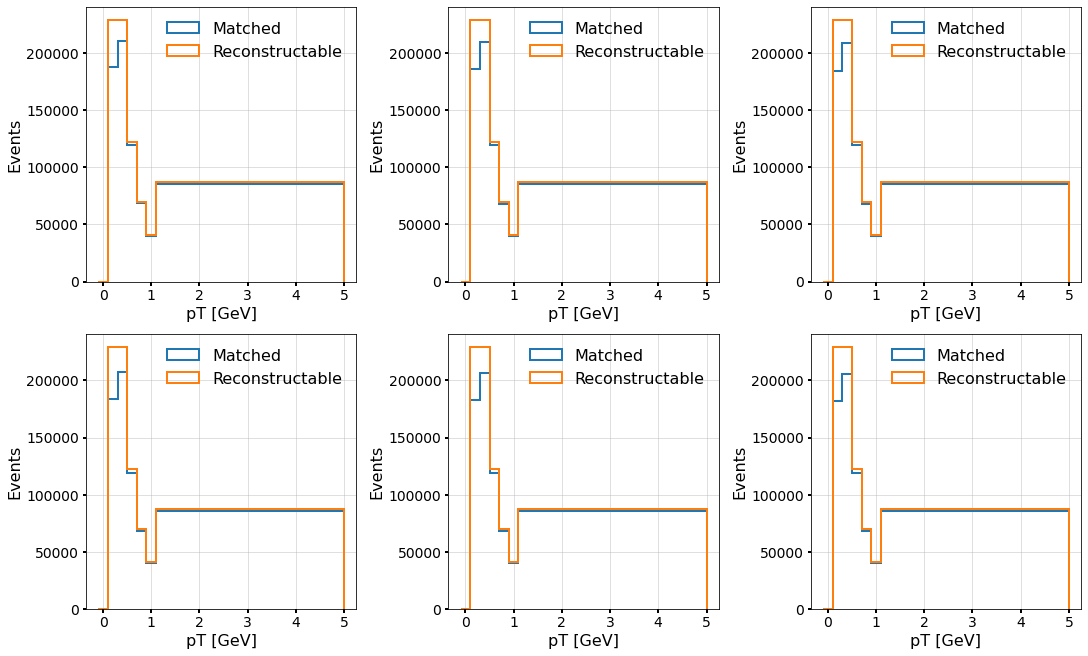

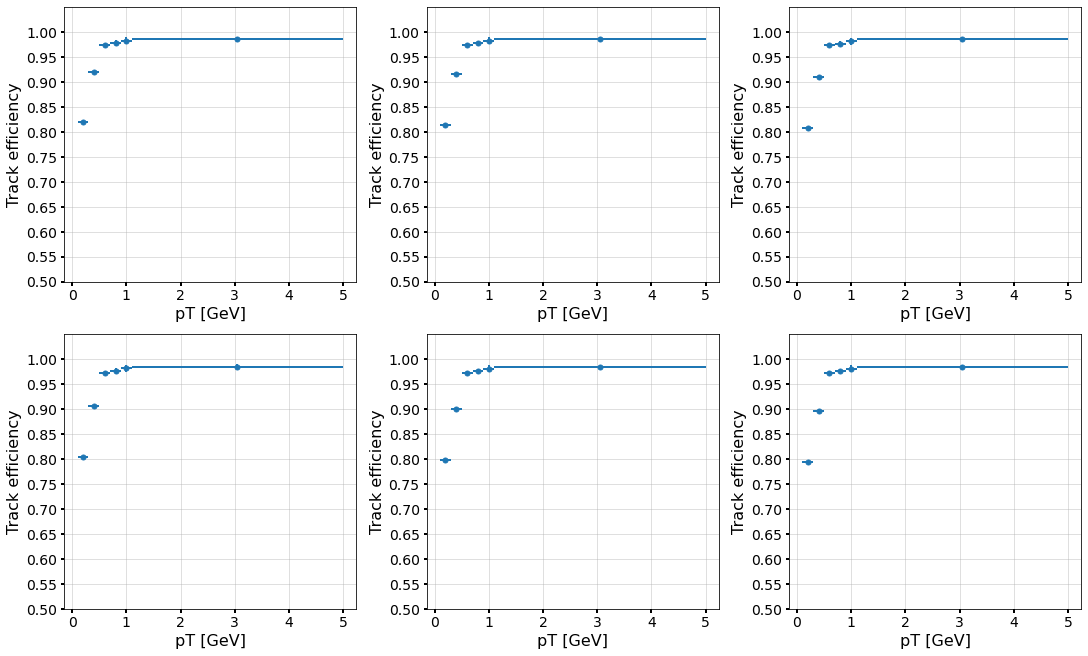

In [11]:
fig,ax1 = plt.subplots(2,3, figsize = (15,9),constrained_layout=True)
fig,ax2 = plt.subplots(2,3, figsize = (15,9),constrained_layout=True)
ppt_data = {}


for i,n in enumerate(noise_keep):
    curr = list_data[n]
    midx = np.concatenate(curr['matched_idx'], axis=0)
    ppt = np.concatenate(curr['par_pt'], axis=0) 
    
    make_cmp_plot_fn = partial(mcp, xlegend="Matched", ylegend="Reconstructable", 
                           ylabel="Events", ratio_label='Track efficiency')
    x_ppt,x_err,y_ppt,y_err,m_vals,n_vals = make_cmp_plot_fn(ppt[midx], ppt, configs=pt_configs,
                                           xlabel="pT [GeV]",ax1=ax1[i//3][i%3],ax2=ax2[i//3][i%3])
    
    print(f"------ Noise {n} ------")
    print(f"Matched = {m_vals[1]}")
    print(f"Total True = {n_vals[1]}")
    
    ppt_data[f'{n}'] = {}
    ppt_data[f'{n}']['x_ppt'] = x_ppt
    ppt_data[f'{n}']['x_err'] = x_err
    ppt_data[f'{n}']['y_ppt'] = y_ppt
    ppt_data[f'{n}']['y_err'] = y_err
    ppt_data[f'{n}']['matched'] = m_vals
    ppt_data[f'{n}']['true'] = n_vals

------ Noise 4 % ------
bin1 = 0.9955297549203574 +- 0.0030720415237559264
------ Noise 8 % ------
bin1 = 0.9903754340793243 +- 0.0030601187947738822
------ Noise 12 % ------
bin1 = 0.9856249079585564 +- 0.0030491254738202076
------ Noise 16 % ------
bin1 = 0.9803708260689872 +- 0.0030369616280118
------ Noise 20 % ------
bin1 = 0.976218866239436 +- 0.0030273454004755


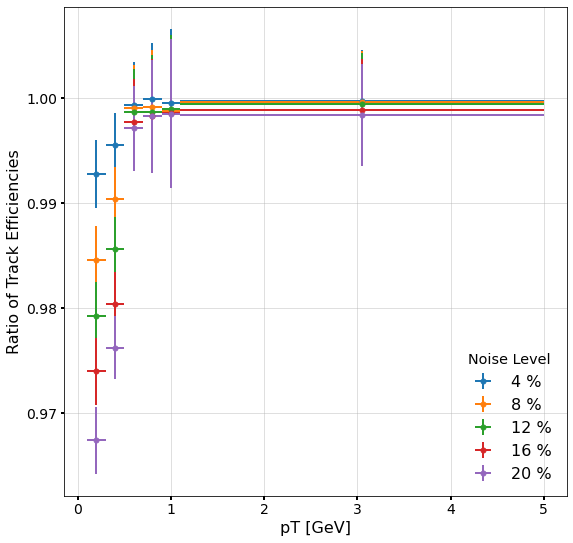

In [47]:
fig,ax4 = plt.subplots(1,1, figsize = (9,9))
noises = ['0.2','0.4','0.6','0.8','1'] 

for n in noises:
    print(f"------ Noise {float(n)*0.2*100:.0f} % ------")
    xvals = np.array(ppt_data[n]['x_ppt'])
    x_err = np.array(ppt_data[n]['x_err'])
    num = np.array(ppt_data[n]['matched']).astype(np.float)
#     print(f"x = {num[1]}")
#     print(f"x_err = {x_err[1]}")
    
    den = np.array(ppt_data['0']['matched']).astype(np.float)
#     print(f"y = {den[1]}")
    
    ratio, ratio_err = get_ratio(num,den)
#     print(f"{ratio[1]} +- {ratio_err[1]}")
    print(f"bin1 = {ratio[1]} +- {ratio_err[1]}")
    
    
    
    ax4.errorbar(xvals, ratio, yerr=ratio_err, xerr = x_err, fmt='o', lw=2, label = f'{float(n)*0.2*100:.0f} %')
    ax4.set_xlabel('pT [GeV]')
    ax4.set_ylabel('Ratio of Track Efficiencies')
    ax4.grid(True)
    ax4.legend(title='Noise Level', loc='lower right', title_fontsize='x-large')
    
plt.savefig('/global/homes/c/caditi97/exatrkx-iml2020/notebooks/noise_studies/trkeff_pt.pdf')

------ Noise 4 % ------
x = 39973.0
x_err = 1.95
y = 39992.0
bin5 = 0.9997431946584489 +- 0.004830833040753155
------ Noise 8 % ------
x = 39942.0
x_err = 1.95
y = 39992.0
bin5 = 0.9996031190176028 +- 0.00483032541762814
------ Noise 12 % ------
x = 39950.0
x_err = 1.95
y = 39992.0
bin5 = 0.9994396974366158 +- 0.004829733183153201
------ Noise 16 % ------
x = 39935.0
x_err = 1.95
y = 39992.0
bin5 = 0.9989027408133726 +- 0.004827787213006611
------ Noise 20 % ------
x = 39933.0
x_err = 1.95
y = 39992.0
bin5 = 0.9983891301302703 +- 0.004825925768584645


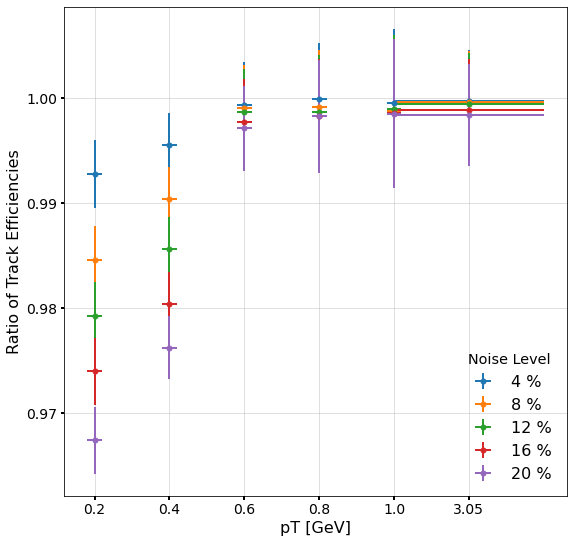

In [42]:
fig,ax5 = plt.subplots(1,1, figsize = (9,9))
noises = ['0.2','0.4','0.6','0.8','1'] 

for n in noises:
    print(f"------ Noise {float(n)*0.2*100:.0f} % ------")
    xvals = np.array(ppt_data[n]['x_ppt'])
    x_err = np.array(ppt_data[n]['x_err'])
    
#     x_err[:-1] = (len(ratio)-2) + 
    
    num = np.array(ppt_data[n]['matched']).astype(np.float)
    print(f"x = {num[5]}")
    print(f"x_err = {x_err[5]}")
    
    den = np.array(ppt_data['0']['matched']).astype(np.float)
    print(f"y = {den[5]}")
    
    ratio, ratio_err = get_ratio(num,den)
    print(f"bin5 = {ratio[5]} +- {ratio_err[5]}")
    
    
    ax5.errorbar(np.arange(len(ratio)), ratio, yerr=ratio_err, xerr = [0.1 , 0.1 , 0.1 , 0.1 , 0.1,1], fmt='o', lw=2, label = f'{float(n)*0.2*100:.0f} %')
    ax5.xaxis.set_ticks(np.arange(len(ratio)))
    ax5.xaxis.set_ticklabels([0.2 , 0.4 , 0.6 , 0.8 , 1.  , 3.05])
    ax5.set_xlabel('pT [GeV]')
    ax5.set_ylabel('Ratio of Track Efficiencies')
    ax5.grid(True)
    ax5.legend(title='Noise Level', loc='lower right', title_fontsize='x-large')

In [45]:
np.array(ppt_data['1']['x_err'])

array([0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 1.95])

In [46]:
np.array(ppt_data['1']['x_ppt'])

array([0.2 , 0.4 , 0.6 , 0.8 , 1.  , 3.05])

In [40]:
[0.5*(x[1]+x[0]) for x in pairwise([0, 0.2 , 0.4 , 0.6 , 0.8 , 1.  , 1.2])][1:]

[0.30000000000000004, 0.5, 0.7, 0.9, 1.1]